In [25]:
!pip install tensorflow matplotlib seaborn scikit-learn emoji wordcloud


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [27]:
from google.colab import files

# Upload Titanic dataset
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print("✅ File uploaded successfully!")
print("📊 Dataset Preview:\n", df.head())


Saving tested.csv to tested (3).csv
✅ File uploaded successfully!
📊 Dataset Preview:
    PassengerId  Survived  Pclass  \
0          892         0       3   
1          893         1       3   
2          894         0       2   
3          895         0       3   
4          896         1       3   

                                           Name     Sex   Age  SibSp  Parch  \
0                              Kelly, Mr. James    male  34.5      0      0   
1              Wilkes, Mrs. James (Ellen Needs)  female  47.0      1      0   
2                     Myles, Mr. Thomas Francis    male  62.0      0      0   
3                              Wirz, Mr. Albert    male  27.0      0      0   
4  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0      1      1   

    Ticket     Fare Cabin Embarked  
0   330911   7.8292   NaN        Q  
1   363272   7.0000   NaN        S  
2   240276   9.6875   NaN        Q  
3   315154   8.6625   NaN        S  
4  3101298  12.2875   NaN        S  


In [28]:
# Combine text fields: Name + Sex + Embarked
df['combined_text'] = (
    df['Name'].astype(str) + " " +
    df['Sex'].astype(str) + " " +
    df['Embarked'].astype(str)
)

# Input = text, Label = Passenger Class (Pclass)
texts = df['combined_text'].astype(str).values
labels = df['Pclass'].values
survival = df['Survived'].values  # keep survival info for lookup later

# Lowercase
texts = [t.lower() for t in texts]

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(texts, labels_encoded, test_size=0.2, random_state=42)

# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
max_len = 30
X_train_pad = pad_sequences(train_sequences, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(test_sequences, maxlen=max_len, padding='post')

print("✅ Example combined text:\n", df['combined_text'].iloc[0])


✅ Example combined text:
 Kelly, Mr. James male Q


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127874 (\N{BIRTHDAY CAKE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


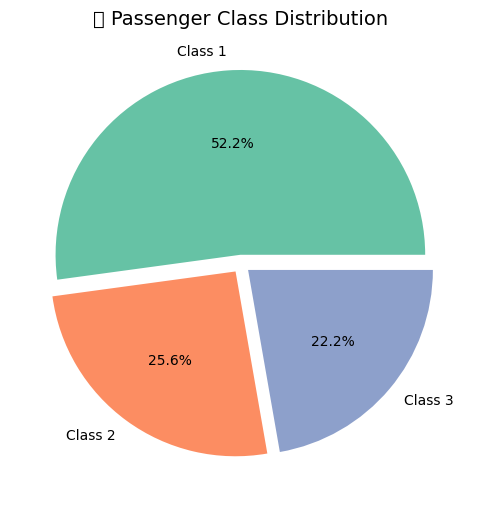

In [29]:
plt.figure(figsize=(6,6))
df['Pclass'].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=[f"Class {c}" for c in sorted(df['Pclass'].unique())],
    colors=sns.color_palette("Set2"),
    explode=[0.05,0.05,0.05]
)
plt.title("🎂 Passenger Class Distribution", fontsize=14)
plt.ylabel("")
plt.show()


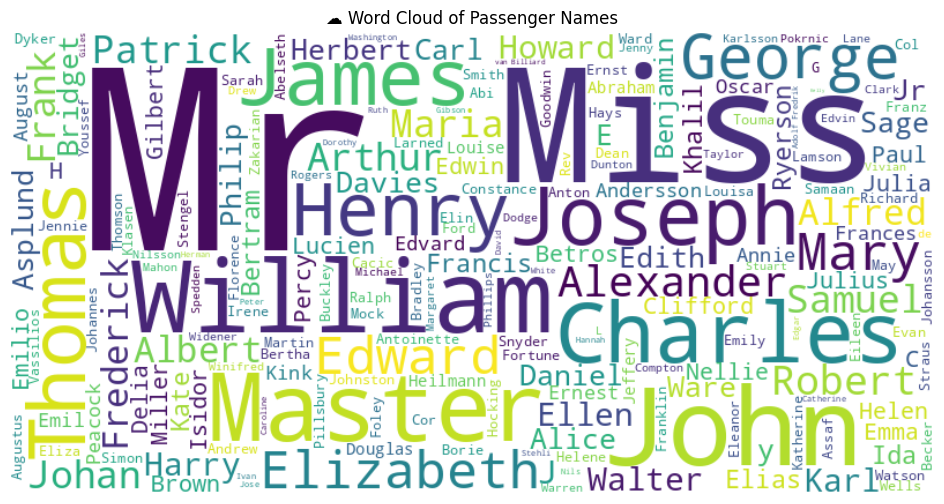

In [30]:
text_data = " ".join(df['Name'].astype(str).values)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_data)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("☁️ Word Cloud of Passenger Names")
plt.show()


In [31]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(labels_encoded)), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))


Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.4318 - loss: 1.0801 - val_accuracy: 0.5000 - val_loss: 1.0411
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.4785 - loss: 1.0843 - val_accuracy: 0.5000 - val_loss: 1.0407
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.5414 - loss: 1.0022 - val_accuracy: 0.5000 - val_loss: 1.0444
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5298 - loss: 1.0408 - val_accuracy: 0.5000 - val_loss: 1.0449
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5706 - loss: 1.0046 - val_accuracy: 0.5000 - val_loss: 1.0408


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


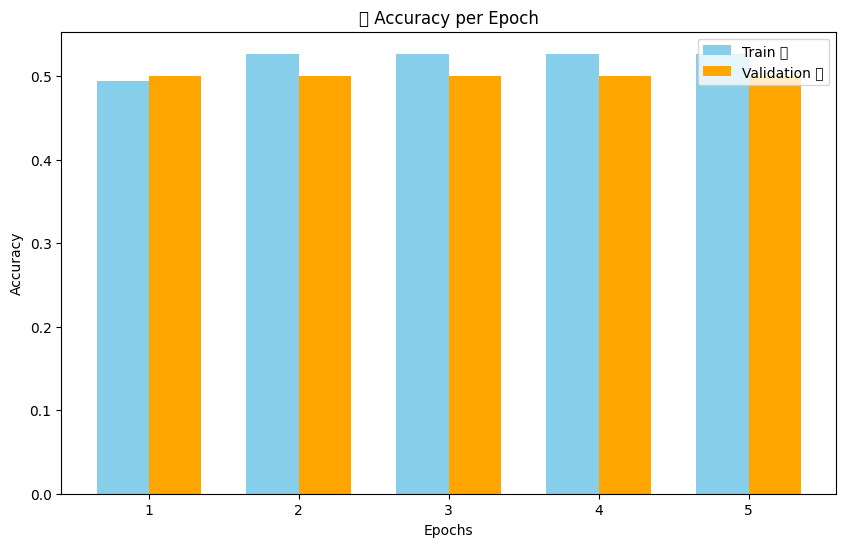

In [33]:
epochs = range(1, len(history.history['accuracy'])+1)

plt.figure(figsize=(10,6))
bar_width = 0.35

plt.bar([e - bar_width/2 for e in epochs], history.history['accuracy'],
        width=bar_width, label=emoji.emojize("Train 📈"), color="skyblue")
plt.bar([e + bar_width/2 for e in epochs], history.history['val_accuracy'],
        width=bar_width, label=emoji.emojize("Validation ✅"), color="orange")

plt.xticks(epochs)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("📊 Accuracy per Epoch")
plt.legend()
plt.show()


1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


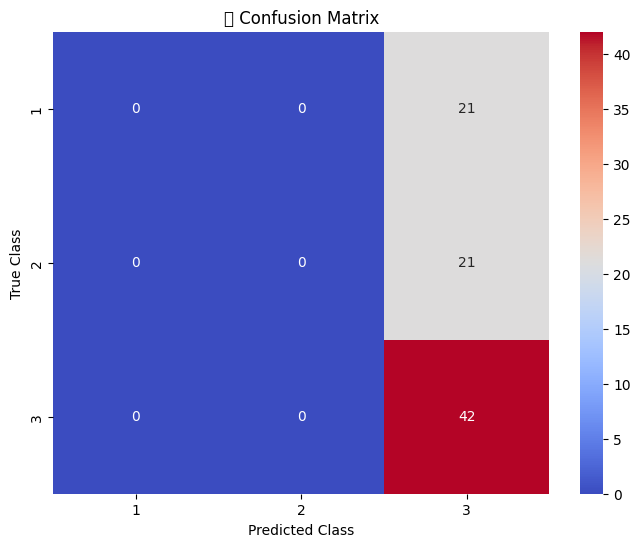

              precision    recall  f1-score   support

     Class 1       0.00      0.00      0.00        21
     Class 2       0.00      0.00      0.00        21
     Class 3       0.50      1.00      0.67        42

    accuracy                           0.50        84
   macro avg       0.17      0.33      0.22        84
weighted avg       0.25      0.50      0.33        84



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
y_pred = np.argmax(model.predict(X_test_pad), axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("🌈 Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

print(classification_report(y_test, y_pred, target_names=[f"Class {c}" for c in sorted(df['Pclass'].unique())]))


In [35]:
def classify_passenger(name):
    # Search dataset
    match = df[df['Name'].str.contains(name, case=False, na=False)]
    if match.empty:
        print("❌ No passenger found with that name.")
        return

    # Prepare text
    text = match.iloc[0]['combined_text'].lower()
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')

    # Predict class
    pred = model.predict(pad)
    predicted_class = label_encoder.classes_[np.argmax(pred)]
    confidence = np.max(pred)

    # Survival info
    survived = match.iloc[0]['Survived']
    survival_status = "🟢 Survived" if survived == 1 else "🔴 Did Not Survive"

    print(f"👤 Passenger: {match.iloc[0]['Name']}")
    print(f"📊 Predicted Class: {predicted_class}  (Confidence {confidence:.2f})")
    print(f"💀 Survival Status: {survival_status}")

# Example
classify_passenger("Kelly")
classify_passenger("Wilkes")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
👤 Passenger: Kelly, Mr. James
📊 Predicted Class: 3  (Confidence 0.51)
💀 Survival Status: 🔴 Did Not Survive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
👤 Passenger: Wilkes, Mrs. James (Ellen Needs)
📊 Predicted Class: 3  (Confidence 0.51)
💀 Survival Status: 🟢 Survived
